<a href="https://colab.research.google.com/github/lucasbarretto/MNIST_GANN/blob/master/MLP_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda")

In [2]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

print('loaded modules and dataset')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
loaded modules and dataset


In [3]:
# define discriminator class
class Discriminator(nn.Module):
    def __init__(self,i,n,o):
        super(Discriminator, self).__init__()
        self.l1 = nn.Linear(i,4*n,bias=True)
        self.l2 = nn.Linear(4*n,2*n, bias=True)
        self.l3 = nn.Linear(2*n,n, bias=True)
        self.l4 = nn.Linear(n,o, bias=True)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(-1,28*28)
        x = F.leaky_relu(self.l1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.l2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.l3(x), 0.2)
        x = self.dropout(x)
        x = torch.sigmoid(self.l4(x))
        return x

# define generator class
class Generator(nn.Module):
    def __init__(self,i,n,o):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(i,n,bias=True)
        self.l2 = nn.Linear(n,2*n, bias=True)
        self.l3 = nn.Linear(2*n,4*n, bias=True)
        self.l4 = nn.Linear(4*n,o, bias=True)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.leaky_relu(self.l1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.l2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.l3(x), 0.2)
        x = self.dropout(x)
        x = torch.tanh(self.l4(x))
        return x

In [0]:
# generate points from latent space distribution
def generateLatentPoints(z_i, batch_size):
    return torch.randn(batch_size, z_i, device=device)

# function to interpolate two points from the latent space
def interpolateLatentPoints(G, p1, p2, numSamples=10, mode='linear'):
    ratios = np.linspace(0, 1, numSamples)
    
    if mode == 'linear':
        z = []
        for ratio in ratios:
            v = (1.0 - ratio) * p1 + ratio * p2
            z.append(v.tolist())

    elif mode == 'spherical':
        return 0
    
    z = torch.tensor(z).to(device)
    return z

In [0]:
# function to print sample images
def printImages(images, num_rows=1):
    for i in range(len(images)):
        ax = plt.subplot(num_rows,len(images),i+1)
        ax.set_axis_off()
        ax = plt.imshow(images[i].view(28,28).cpu().numpy(), cmap='gray')
    plt.show()
    print(sampleImages)

# function to evaluate model
def evaluateModel(G, num_rows=1, mode='random', interpolation_mode='linear'):
    if mode == 'random':
        z = generateLatentPoints(z_i, num_rows*10)
    
    elif mode == 'interpolate':
        z = interpolateLatentPoints(G, p1, p2, mode=interpolation_mode)
    
    with torch.no_grad():
        sampleImages = G(z)
    
    printImages(sampleImages)

In [0]:
# function to generate labels
def generateLabels(arg, batch_size, smooth='False'):
    if smooth == 'True':
        # true labels are in range [0.8, 1.2]
        if arg == 'True':
            labels = 1.2-0.4*torch.rand(batch_size, 1, device=device)
        
        # false labels are in range [0.0, 0.3]
        if arg == 'False':
            labels = 0.2*torch.rand(batch_size, 1, device=device)
    
    elif smooth == 'False':
        if arg == 'True':
            # true labels are 1s
            labels = torch.ones(batch_size, 1, device=device)
        if arg == 'False':
            # false labels are 0s
            labels = torch.zeros(batch_size, 1, device=device)
    
    return labels

In [0]:
def train(G, D, trainloader, max_epochs):
    print('started training')
    
    criterion = nn.BCELoss()  # binary cross entropy loss
    
    # define optimizers
    d_optimizer = optim.SGD(D.parameters(), lr = 0.001, momentum=0.8)
    g_optimizer = optim.SGD(G.parameters(), lr = 0.001, momentum=0.8)

    # initialize loss data structures
    d_loss_data = []
    g_loss_data = []

    for epoch in range(max_epochs):

        for i,data in enumerate(trainloader,0):                
            realImages, realLabels = data[0].to(device), data[1].to(device)
            batchSize = realLabels.size(0)
            
            d_optimizer.zero_grad()
            
            # train D on real samples (RS = Real Samples)
            d_prediction_RS = D(realImages)
            d_labels_RS = generateLabels('True', batchSize, smooth='False') # samples belong to the real data
            d_loss_RS = criterion(d_prediction_RS, d_labels_RS) # D loss for real samples
            d_loss_RS.backward() # compute gradients without changing D's parameters

            # train D on fake samples (FS = Fake Samples)
            z = generateLatentPoints(z_i, batchSize)
            fakeImages = G(z)
            d_prediction_FS = D(fakeImages)
            d_labels_FS = generateLabels('False', batchSize, smooth='False') # samples belong to the generated data
            d_loss_FS = criterion(d_prediction_FS, d_labels_FS) # D loss for fake samples
            d_loss_FS.backward() # compute gradients without changing D's parameters
        
            d_loss = d_loss_RS + d_loss_FS
            d_optimizer.step()

            # train G
            g_optimizer.zero_grad()
            z = generateLatentPoints(z_i, batchSize)
            fakeImages = G(z)
            d_loss_g = D(fakeImages)
            d_labels_g = generateLabels('True', batchSize, smooth='False')
            g_loss = criterion(d_loss_g, d_labels_g)

            g_loss.backward()
            g_optimizer.step()

        # print losses
        if epoch % 1 == 0:
            print('Epoch: %s - D: (%s) | G: (%s)' % (epoch, d_loss.item(), g_loss.item()))

        if epoch % 1 == 0:
            # print samples of generated images through training
            evaluateModel(G,mode='random')

        # store losses
        d_loss_data.append(d_loss.item())
        g_loss_data.append(g_loss.item())

    return G, D, g_loss_data, d_loss_data

In [0]:
# discriminator hyperparameters
d_i = 28*28 # discriminator input size
d_n = 21 # discriminator hidden layer size
d_o = 1 # discriminator output size

# generator hyperparameters
z_i = 100 # random distribution input size
g_n = 32 # generator hidden layer size
g_o = 28*28 # generator output size

# initiate the discriminator network
D = Discriminator(d_i, d_n, d_o).to(device)

# initiate the generator network
G = Generator(z_i, g_n, g_o).to(device)

# training hyperparameters
maxEpochs = 100

started training
Epoch: 0 - D: (0.8709319829940796) | G: (1.4753360748291016)


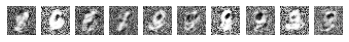

Epoch: 1 - D: (1.0833185911178589) | G: (1.2780841588974)


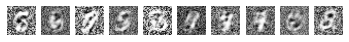

Epoch: 2 - D: (0.8915553092956543) | G: (1.444612741470337)


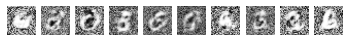

Epoch: 3 - D: (0.9902467727661133) | G: (1.27876877784729)


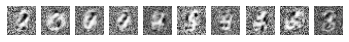

Epoch: 4 - D: (0.7373707294464111) | G: (1.475682258605957)


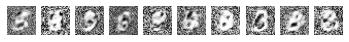

Epoch: 5 - D: (0.9295268654823303) | G: (1.4124644994735718)


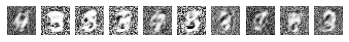

Epoch: 6 - D: (0.7719618678092957) | G: (1.4590175151824951)


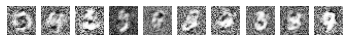

Epoch: 7 - D: (0.7762584686279297) | G: (1.1864681243896484)


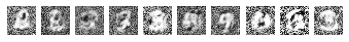

Epoch: 8 - D: (0.9334316253662109) | G: (1.300649642944336)


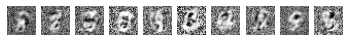

Epoch: 9 - D: (0.8962546586990356) | G: (1.5095410346984863)


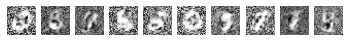

Epoch: 10 - D: (0.8359522819519043) | G: (1.4438884258270264)


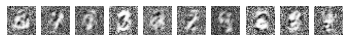

Epoch: 11 - D: (1.124821424484253) | G: (1.288769245147705)


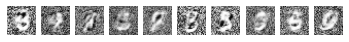

Epoch: 12 - D: (0.828524649143219) | G: (1.539102554321289)


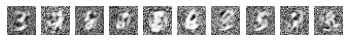

Epoch: 13 - D: (1.0190942287445068) | G: (1.4424458742141724)


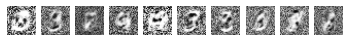

Epoch: 14 - D: (0.8573647141456604) | G: (1.3627281188964844)


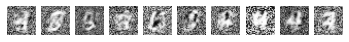

Epoch: 15 - D: (0.8355680704116821) | G: (1.3937788009643555)


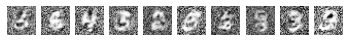

Epoch: 16 - D: (0.9223273992538452) | G: (1.4377089738845825)


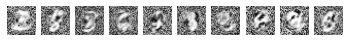

Epoch: 17 - D: (0.9375454783439636) | G: (1.5558853149414062)


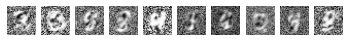

Epoch: 18 - D: (0.8008207082748413) | G: (1.4762777090072632)


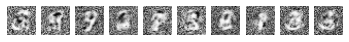

Epoch: 19 - D: (0.7953197956085205) | G: (1.43345308303833)


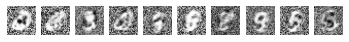

Epoch: 20 - D: (0.8120750784873962) | G: (1.4008121490478516)


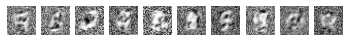

Epoch: 21 - D: (0.9543176889419556) | G: (1.440398097038269)


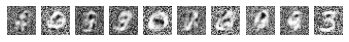

Epoch: 22 - D: (1.0442478656768799) | G: (1.3947758674621582)


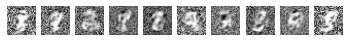

Epoch: 23 - D: (0.7920881509780884) | G: (1.404897928237915)


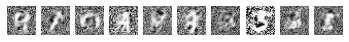

Epoch: 24 - D: (0.8877003788948059) | G: (1.4757052659988403)


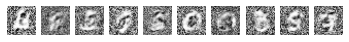

Epoch: 25 - D: (0.7829321622848511) | G: (1.3030935525894165)


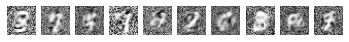

Epoch: 26 - D: (0.8509091734886169) | G: (1.1896355152130127)


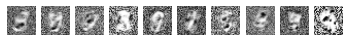

Epoch: 27 - D: (0.9091579914093018) | G: (1.5310258865356445)


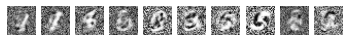

Epoch: 28 - D: (0.9591500163078308) | G: (1.3424317836761475)


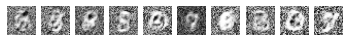

Epoch: 29 - D: (0.87163907289505) | G: (1.4684869050979614)


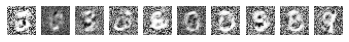

Epoch: 30 - D: (0.8361035585403442) | G: (1.3633784055709839)


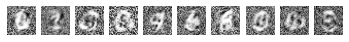

Epoch: 31 - D: (0.65425705909729) | G: (1.2592589855194092)


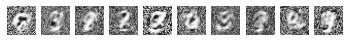

Epoch: 32 - D: (1.140161395072937) | G: (1.314516544342041)


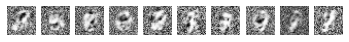

Epoch: 33 - D: (0.9987401962280273) | G: (1.4211578369140625)


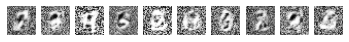

Epoch: 34 - D: (1.2569366693496704) | G: (1.2715951204299927)


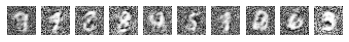

Epoch: 35 - D: (1.1222273111343384) | G: (1.4325737953186035)


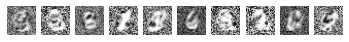

Epoch: 36 - D: (0.9500689506530762) | G: (1.2075693607330322)


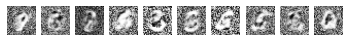

Epoch: 37 - D: (0.9282182455062866) | G: (1.4104290008544922)


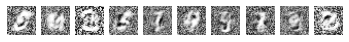

Epoch: 38 - D: (1.0982842445373535) | G: (1.2079315185546875)


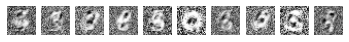

Epoch: 39 - D: (0.8105877637863159) | G: (1.456894040107727)


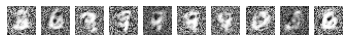

Epoch: 40 - D: (0.8467743992805481) | G: (1.2561335563659668)


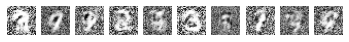

Epoch: 41 - D: (1.2810405492782593) | G: (1.303300142288208)


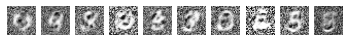

Epoch: 42 - D: (1.1120518445968628) | G: (1.209113597869873)


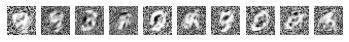

Epoch: 43 - D: (0.859779953956604) | G: (1.2714895009994507)


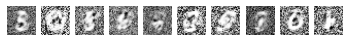

Epoch: 44 - D: (0.969190239906311) | G: (1.3018715381622314)


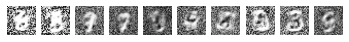

Epoch: 45 - D: (0.8601003885269165) | G: (1.3538007736206055)


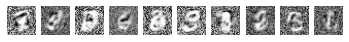

Epoch: 46 - D: (0.7961431741714478) | G: (1.4494178295135498)


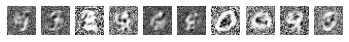

Epoch: 47 - D: (0.9856119751930237) | G: (1.3984556198120117)


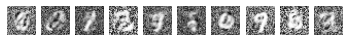

Epoch: 48 - D: (0.5866079330444336) | G: (1.2571991682052612)


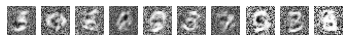

Epoch: 49 - D: (1.13851797580719) | G: (1.4497015476226807)


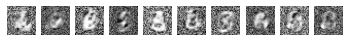

Epoch: 50 - D: (0.9824178218841553) | G: (1.2899234294891357)


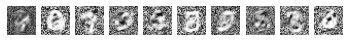

Epoch: 51 - D: (0.744789719581604) | G: (1.3936047554016113)


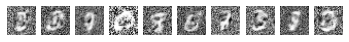

Epoch: 52 - D: (0.8250601291656494) | G: (1.4819859266281128)


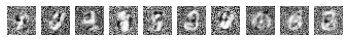

Epoch: 53 - D: (0.6984043121337891) | G: (1.442901611328125)


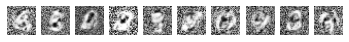

Epoch: 54 - D: (0.9109028577804565) | G: (1.2146085500717163)


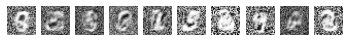

Epoch: 55 - D: (1.0134028196334839) | G: (1.4107962846755981)


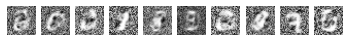

Epoch: 56 - D: (1.1046475172042847) | G: (1.2681658267974854)


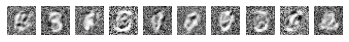

Epoch: 57 - D: (0.9123544096946716) | G: (1.2135262489318848)


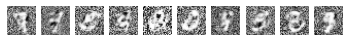

Epoch: 58 - D: (0.8340892791748047) | G: (1.3723737001419067)


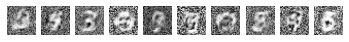

Epoch: 59 - D: (0.8280428647994995) | G: (1.3434360027313232)


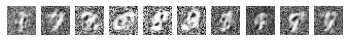

Epoch: 60 - D: (0.8987228870391846) | G: (1.1462026834487915)


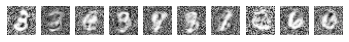

Epoch: 61 - D: (0.9293285608291626) | G: (1.301988124847412)


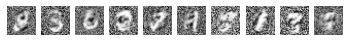

Epoch: 62 - D: (1.129781723022461) | G: (1.278493046760559)


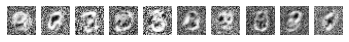

Epoch: 63 - D: (0.8130176067352295) | G: (1.5450026988983154)


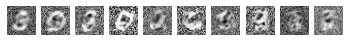

Epoch: 64 - D: (0.9199094772338867) | G: (1.1486380100250244)


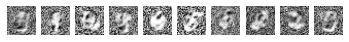

Epoch: 65 - D: (1.067215919494629) | G: (1.2934986352920532)


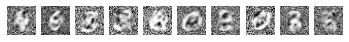

Epoch: 66 - D: (1.0338705778121948) | G: (1.3014273643493652)


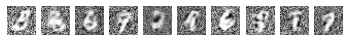

Epoch: 67 - D: (0.9568305611610413) | G: (1.2057979106903076)


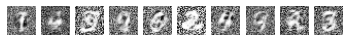

Epoch: 68 - D: (0.8630993366241455) | G: (1.3279783725738525)


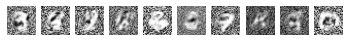

Epoch: 69 - D: (0.9360634088516235) | G: (1.3439427614212036)


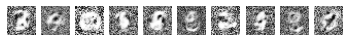

Epoch: 70 - D: (1.270598292350769) | G: (1.3923348188400269)


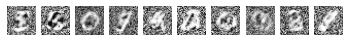

Epoch: 71 - D: (1.1943284273147583) | G: (1.2595471143722534)


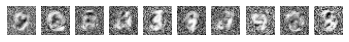

Epoch: 72 - D: (0.826433539390564) | G: (1.3843989372253418)


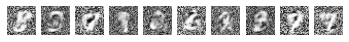

Epoch: 73 - D: (0.8855461478233337) | G: (1.2051420211791992)


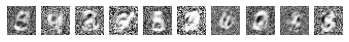

Epoch: 74 - D: (0.8817398548126221) | G: (1.2861473560333252)


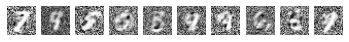

Epoch: 75 - D: (0.9486833810806274) | G: (1.218310832977295)


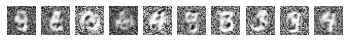

Epoch: 76 - D: (1.1425236463546753) | G: (1.461374282836914)


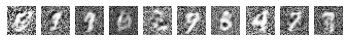

Epoch: 77 - D: (1.09572172164917) | G: (1.1989247798919678)


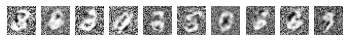

Epoch: 78 - D: (0.8128311038017273) | G: (1.0942833423614502)


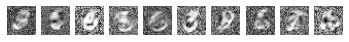

Epoch: 79 - D: (1.1549780368804932) | G: (1.3314568996429443)


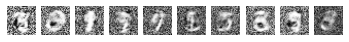

Epoch: 80 - D: (0.6653403043746948) | G: (1.3936439752578735)


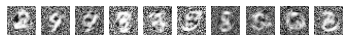

Epoch: 81 - D: (1.1208316087722778) | G: (1.381800889968872)


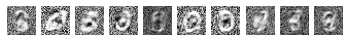

Epoch: 82 - D: (1.1689752340316772) | G: (1.4402059316635132)


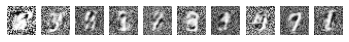

Epoch: 83 - D: (0.9181627035140991) | G: (1.381259560585022)


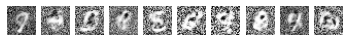

Epoch: 84 - D: (1.1446175575256348) | G: (1.1890242099761963)


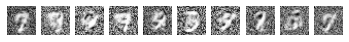

Epoch: 85 - D: (1.192725658416748) | G: (1.2525959014892578)


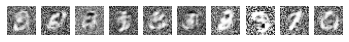

Epoch: 86 - D: (1.144121766090393) | G: (1.2537074089050293)


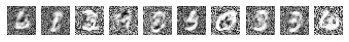

Epoch: 87 - D: (0.7382442951202393) | G: (1.2387462854385376)


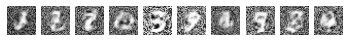

Epoch: 88 - D: (1.0784885883331299) | G: (1.3302867412567139)


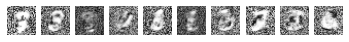

Epoch: 89 - D: (1.1231485605239868) | G: (1.1897761821746826)


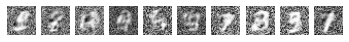

Epoch: 90 - D: (1.1484004259109497) | G: (1.3440005779266357)


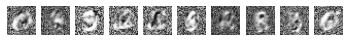

Epoch: 91 - D: (0.8985863327980042) | G: (1.2316527366638184)


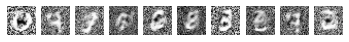

Epoch: 92 - D: (1.1337872743606567) | G: (1.1254980564117432)


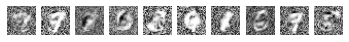

Epoch: 93 - D: (1.0734728574752808) | G: (1.355351448059082)


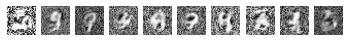

Epoch: 94 - D: (1.0146441459655762) | G: (1.2206127643585205)


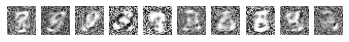

Epoch: 95 - D: (1.0294729471206665) | G: (1.2693625688552856)


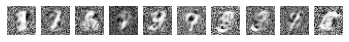

Epoch: 96 - D: (1.0687572956085205) | G: (1.339991807937622)


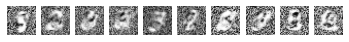

Epoch: 97 - D: (1.080249309539795) | G: (1.2132666110992432)


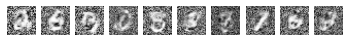

Epoch: 98 - D: (1.1504840850830078) | G: (1.1535732746124268)


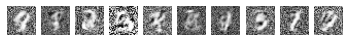

Epoch: 99 - D: (0.920099139213562) | G: (1.0600755214691162)


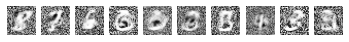

In [30]:
G, D, g_loss, d_loss = train(G, D, trainloader, maxEpochs)

In [3]:
# print loss charts
plt.plot(d_loss, label='Discriminator Loss')
plt.plot(g_loss, label='Generator Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

NameError: ignored

In [2]:
# print interpolated samples
evaluateModel(G, interpolation_mode='interpolate')
evaluateModel(G, interpolation_mode='interpolate')
evaluateModel(G, interpolation_mode='interpolate')

NameError: ignored